In [182]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import nltk
from collections import Counter
import re

In [183]:
df = pd.read_csv('movie_database.csv')

In [184]:
df = df.rename(columns={'summary_sublikescript': 'summary_subslikescript'})

In [185]:
def clean_new_row_stamp(text):
    if pd.isnull(text):
        return text
    else:
        text = re.sub(r'\n', ' ', text) # replace newlines with spaces
        text = re.sub(r'\t', ' ', text) # replace tabs with spaces
        return text

In [186]:
# Removing '\n' and '\t' symbols
df['script'] = df['script'].apply(clean_new_row_stamp)
df['summary_meta'] = df['summary_meta'].apply(clean_new_row_stamp)
df['summary_rotten'] = df['summary_rotten'].apply(clean_new_row_stamp)
df['subtitle'] = df['subtitle'].apply(clean_new_row_stamp)
df['summary_subslikescript'] = df['summary_subslikescript'].apply(clean_new_row_stamp)

In [187]:
# Converting years from float to int value
df['year_rotten'] = df['year_rotten'].fillna(0)
df['year_rotten'] = df['year_rotten'].astype(int)
df['year_meta'] = df['year_meta'].fillna(0)
df['year_meta'] = df['year_meta'].astype(int)

In [188]:
# sometimes movies have same name, but were filmed in different years, we have to drop rows that contain conflicting information

mask = (df['year_rotten'] != 0) & (df['year_meta'] != 0) & (np.abs(df['year_rotten'] - df['year_meta']) > 2)
df = df[~mask]

# remove scripts for which we don't have any summary

df.dropna(subset=['summary_rotten', 'summary_meta', 'summary_subslikescript'], how='all', inplace=True)
df = df.reset_index(drop=True)

In [189]:
# Define a function to count the number of sentences in a given text

def count_sentences(text):
    sentences = nltk.sent_tokenize(text)
    return len(sentences)

# Apply the function to the text column to create a new column with the sentence counts
df['num_sentences'] = df['subtitle'].apply(lambda x: count_sentences(str(x)))

# Replace the text column values with NaN if the number of sentences is less than 200
df.loc[df['num_sentences'] < 200, 'subtitle'] = pd.np.nan

# Drop the 'num_sentences' column 
df.drop('num_sentences', axis=1, inplace=True)

C:\Users\Asus\AppData\Local\Temp\ipykernel_9352\786264965.py:11: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  df.loc[df['num_sentences'] < 200, 'subtitle'] = pd.np.nan


In [190]:
# Corpus size

script = df['script'].dropna()
print('Number of scripts: ', len(script))

subtitle = df['subtitle'].dropna()
print('Number of subtitles: ', len(subtitle))

summary_rotten = df['summary_rotten'].dropna()
print('Number of Rotten Tomatoes summaries : ', len(summary_rotten))

summary_meta = df['summary_meta'].dropna()
print('Number of Metacritics summaries: ', len(summary_meta))

summary_ss = df['summary_subslikescript'].dropna()
print('Number of Subslikescript summaries: ', len(summary_ss))

Number of scripts:  943
Number of subtitles:  767
Number of Rotten Tomatoes summaries :  781
Number of Metacritics summaries:  835
Number of Subslikescript summaries:  786


In [191]:
# Counting the number of sentences 

data = [script, subtitle, summary_rotten, summary_meta, summary_ss]
names = ['scripts', 'subtitles', 'Rotten Totamoes summaries', 'Metacritics summaries', 'Subslikescript summaries']

for i in range(len(data)):
    sentences_counts = []
    for text in data[i]:
        sentences = nltk.sent_tokenize(text)
        num_sentences = len(sentences)
        sentences_counts.append(num_sentences)
    print('Sentences in {}:'.format(names[i]))    
    print('Min:', min(sentences_counts))
    print('Average:', int(sum(sentences_counts)/len(sentences_counts)))
    print('Max:', max(sentences_counts))
    print('\n')

Sentences in scripts:
Min: 334
Average: 2807
Max: 5345


Sentences in subtitles:
Min: 201
Average: 1515
Max: 11077


Sentences in Rotten Totamoes summaries:
Min: 1
Average: 3
Max: 7


Sentences in Metacritics summaries:
Min: 1
Average: 2
Max: 12


Sentences in Subslikescript summaries:
Min: 1
Average: 4
Max: 22




In [192]:
# Counting the number of words and computing TTR

for i in range(len(data)):
    words_counts = []
    ttr_all = []
    for text in data[i]:
        words = nltk.word_tokenize(text)
        num_words = len(words)
        words_counts.append(num_words)
        types = len(set(words))
        ttr = types/num_words
        ttr_all.append(ttr)
    
    print('Words in {}:'.format(names[i])) 
    print('Min:', min(words_counts))
    print('Average:', int(sum(words_counts)/len(words_counts)))
    print('Max:', max(words_counts))
    print('\n')
    print('TTR in {}:'.format(names[i])) 
    print('Min:', min(ttr_all))
    print('Average:', sum(ttr_all)/len(ttr_all))
    print('Max:', max(ttr_all))
    print('\n')

Words in scripts:
Min: 4313
Average: 29465
Max: 64312


TTR in scripts:
Min: 0.0707502469907454
Average: 0.1417603818083703
Max: 0.30952932993276144


Words in subtitles:
Min: 1521
Average: 11746
Max: 49988


TTR in subtitles:
Min: 0.002127438771274388
Average: 0.15514979215882835
Max: 0.2931253978357734


Words in Rotten Totamoes summaries:
Min: 7
Average: 82
Max: 123


TTR in Rotten Totamoes summaries:
Min: 0.6
Average: 0.7569169232634937
Max: 1.0


Words in Metacritics summaries:
Min: 10
Average: 64
Max: 320


TTR in Metacritics summaries:
Min: 0.534375
Average: 0.8281717290645512
Max: 1.0


Words in Subslikescript summaries:
Min: 12
Average: 123
Max: 616


TTR in Subslikescript summaries:
Min: 0.4708029197080292
Average: 0.6961358389729334
Max: 1.0




In [193]:
def convert_to_list(x):
    if pd.isnull(x):
        return x
    elif isinstance(x, str):
        x = x.strip("[]'").replace("'", "").split(", ")
        return x
    
def extract_genres(text):
     if pd.isnull(text):
        return text
     else:
        text = re.sub(r'&', '', text)
        text = re.sub(r'/', ' ', text)
        text = text.lower().split()
        return text

df['genre_meta'] = df['genre_meta'].apply(convert_to_list)
df['genre_rotten'] = df['genre_rotten'].apply(extract_genres)
df['genre_meta'] = df['genre_meta'].apply(lambda x: [genre.lower() for genre in x] if isinstance(x, list) else pd.np.nan)


C:\Users\Asus\AppData\Local\Temp\ipykernel_9352\1982395373.py:19: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  df['genre_meta'] = df['genre_meta'].apply(lambda x: [genre.lower() for genre in x] if isinstance(x, list) else pd.np.nan)


In [194]:
common_genres_list = []
for i in range(len(df)):
    genres1 = df.loc[i, 'genre_rotten']
    genres2 = df.loc[i, 'genre_meta']
    if isinstance(genres1, list) and len(genres1) > 0:
        if isinstance(genres2, list) and len(genres2) > 0:
            common_genres = list(set(genres1).intersection(genres2))
        else:
            common_genres = genres1
    elif isinstance(genres2, list) and len(genres2) > 0:
        common_genres = genres2
    else:
        common_genres = pd.np.nan
    common_genres_list.append(common_genres)
    
df['common_genres'] = common_genres_list
df['common_genres']

C:\Users\Asus\AppData\Local\Temp\ipykernel_9352\1851269012.py:13: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  common_genres = pd.np.nan


In [195]:
# Putting all genres into one list
all_genres = []
for i in range(len(df['common_genres'])):
    if isinstance(df['common_genres'][i], list):
        all_genres.extend(df['common_genres'][i]) 

# Counting how many times each movie genre occurs in the data
genres_occurrence = Counter(all_genres)
genres_occurrence = list(genres_occurrence.items())
genres_sorted = sorted(genres_occurrence, key=lambda x: x[1], reverse=True)
genres_sorted

[('drama', 369),
 ('comedy', 271),
 ('thriller', 182),
 ('action', 133),
 ('sci-fi', 96),
 ('crime', 89),
 ('romance', 85),
 ('mystery', 85),
 ('adventure', 85),
 ('horror', 84),
 ('fantasy', 50),
 ('family', 42),
 ('biography', 41),
 ('history', 20),
 ('war', 19),
 ('musical', 12),
 ('western', 10),
 ('animation', 6),
 ('music', 4),
 ('sport', 3),
 ('kids', 2),
 ('film-noir', 1)]

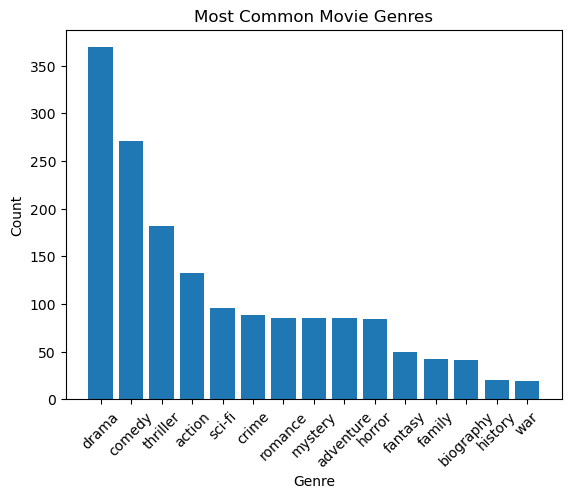

In [196]:
# Get the top 15 genres
top_genres = genres_sorted[:15]

# Extract the genre names and counts from the top 15 tuples
genres = [g[0] for g in top_genres]
counts = [g[1] for g in top_genres]

# Create a bar plot
fig, ax = plt.subplots()
ax.bar(genres, counts)
ax.set_xlabel('Genre')
ax.set_ylabel('Count')
ax.set_title('Most Common Movie Genres')
plt.xticks(rotation=45)
plt.show()